## Применение классов dataset и dataloader

In [1]:
import os
import json
from PIL import Image

import torch
import torch.utils.data as data
import torchvision.transforms.v2 as v2
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

#### Создание класса для загрузки датасета

1 способ загрузить данные (через создание собственного класса)

In [2]:
class DigitDataset(data.Dataset):
    def __init__(self, path, train=True, transform=None):
        self.path = os.path.join(path, 'train' if train else 'test')
        self.transform = transform

        with open(os.path.join(path, 'format.json'), 'r') as fp:
            self.format = json.load(fp)

        self.length = 0
        self.files = []
        self.targets = torch.eye(10)

        for _dir, _target in self.format.items():
            path = os.path.join(self.path, _dir)
            list_files = os.listdir(path)
            self.length += len(list_files)
            self.files += [(os.path.join(path, cur_file), _target) for cur_file in list_files]  # добавляем все файлы вместе с метками в один список

    def __getitem__(self, item):
        """Обрабатывает картинку и таргет по индексу.
        Таким образом в память загружаются одновременно только несколько изображений,
        следовательно меньше расход оперативной памяти.
        """
        path_file, target = self.files[item]  # получаем номер класса
        t = self.targets[target]  # получаем выходную матрицу для таргета по его индексу
        img = Image.open(path_file)  # загрузили картинку
        
        if self.transform:
            img = self.transform(img).ravel().float() / 255.  # превращаем изображение в заданный формат + нормируем

        return img, t
    
    def __len__(self):
        return self.length

In [5]:
data_path = 'C:\projects\Python\dl\DataBases\MNIST'
to_tensor = v2.ToImage()  # чтобы трансформировать картинку из типа PIL в тензор

In [6]:
d_train = DigitDataset(data_path, train=True, transform=to_tensor)
d_test = DigitDataset(data_path, train=False, transform=to_tensor)

2 способ загрузить данные (через готовый класс ImageFolder)

In [9]:
class RavelTransform(nn.Module):
    def forward(self, item):
        return torch.ravel(item)

In [10]:
to_grayscale = v2.Grayscale()  # переводим из 3 канального вида в 1 канальный
fl = v2.ToDtype(torch.float32, scale=True)  # нормируем + приводим к типу float32
flatten = v2.Lambda(lambda img: torch.ravel(img))  # вытягиваем изображение в вектор
# flatten = RavelTransform()

image_prepare = v2.Compose([to_tensor, to_grayscale, fl, flatten])  # компануем все преобразования выше для обработки картинки

In [11]:
d_train = ImageFolder(os.path.join(data_path, 'train'), transform=image_prepare)
d_test = ImageFolder(os.path.join(data_path, 'test'), transform=image_prepare)

далее использован 1 способ обработки датасета

In [12]:
train_data = data.DataLoader(d_train, batch_size=32, shuffle=True)
test_data = data.DataLoader(d_test, batch_size=32, shuffle=False)

In [13]:
next(iter(train_data))[0].shape, next(iter(train_data))[1].shape

(torch.Size([32, 784]), torch.Size([32]))

In [ ]:
input_shape = next(iter(train_data))[0].shape[0]
output_shape = next(iter(train_data))[0].shape[1]

input_shape, output_shape

(32, 784)

#### Создание нейронной сети

In [50]:
class DigitNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.functional.relu(x)
        x = self.layer2(x)
        # не делаем функцию активации на последнем слое, потому что CrossEntropyLoss требует на вход именно логиты

        return x

In [20]:
model = DigitNN(input_dim=28*28, hidden_dim=32, output_dim=output_shape)

optimizer = optim.Adam(params=model.parameters(), lr=1e-2)
loss_func = nn.CrossEntropyLoss()

epochs = 2

#### Обучения нейронной сети

In [21]:
model.train()

for _e in range(epochs):
    loss_mean = 0  # среднее значение функции потерь по эпохе
    lm_count = 0  # текущее количество слагаемых

    train_tqdm = tqdm(train_data, leave=True)
    for x_train, y_train in train_tqdm:
        predict = model(x_train)
        loss = loss_func(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.3f}")

Epoch [1/2], loss_mean=1.679:   2%|▏         | 41/1875 [00:04<03:05,  9.88it/s]


KeyboardInterrupt: 

#### Валидация нейронной сети

In [58]:
Q = 0

model.eval()
losses = []

for x_test, y_test in tqdm(test_data):
    with torch.no_grad():
        logits = model(x_test)
        predict = torch.argmax(logits, dim=1)
        y_true = torch.argmax(y_test, dim=1)

        losses += [loss_func(logits, y_test)]

        Q += torch.sum(predict == y_true).item()  # рассчитываем точность предсказания (accuracy)
Q /= len(d_test)

100%|██████████| 313/313 [00:02<00:00, 156.39it/s]


In [59]:
import  matplotlib.pyplot as plt

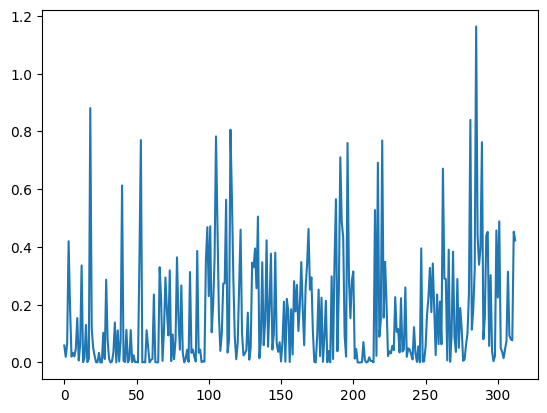

In [60]:
plt.plot(range(len(test_data)), losses)

In [61]:
Q

0.9581